In [2]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from sklearn.model_selection import GroupShuffleSplit

import seaborn as sns
import numpy as np
import re
import os


In [3]:
%load_ext autoreload
%autoreload 2
    
from helpers.utils import _qq_stats_text
from helpers.utils import scree
from helpers.utils import learn_kde
from helpers.utils import score_with_kdes
from helpers.utils import reshape_to_cmat, _site_slice
import helpers.utils 

In [4]:
import sys; print(sys.executable)

plt.rcParams.update({"font.size": 9})

/Users/gc3045/miniconda3/bin/python


In [5]:
plot_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/"
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

barcoded_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/barcoded_tracing_alleles.csv"
colony_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/colony_alleles.csv"
validation_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/preedited_merfish_invitro_alleles.csv"

In [6]:
codebook_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/edit_codebook.csv"

First look at the `preedited_merfish_invitro_alleles.csv`. For each cassette, we have three target sites. The features are in columns: r25-r51. First, I need to extract these features and then rotate them to long format, so that I have a row for every (cellBC, intID, target_site). Note that the order of target sites is: `RNF2, HEK3, EMX1` in the paper, but we let the order be `HEK3`, `EMX1`, `RNF2` according to the order given in `validation_df`. This was also checked using classification error. 

Recall that NaN is the unedited state!

#### Process inputs

In [7]:
validation_df = pd.read_csv(validation_fname)
codebook = pd.read_csv(codebook_fname)

In [8]:
dfw = validation_df.copy().fillna("unedited")
codebook_df = codebook.copy().fillna("unedited")

In [9]:
codebook_df

,site,edit,bit
0,HEK3,GATAG,r25
1,HEK3,AATCG,r26
2,HEK3,GCAAG,r27
3,HEK3,GCGCC,r28
4,HEK3,CTTTG,r29
5,HEK3,ATCAA,r30
6,HEK3,CTCTC,r31
7,HEK3,ATTTA,r32
8,EMX1,GGACA,r33
9,EMX1,ACAAT,r34


In [10]:
dfw

,intID,cellBC,HEK3,EMX1,RNF2,spot,x,y,z,global_x,...,cell_dist,sample,clone,whitelist,RNF2_actual,HEK3_actual,EMX1_actual,RNF2_brightest,HEK3_brightest,EMX1_brightest
0,intID1011,4T1_preedited-1057,CTCTC,AGTAC,ACTCC,226,504,123,20,-765.072,...,0.139511,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
1,intID1011,4T1_preedited-1120,CTCTC,AGTAC,ACTCC,42,1928,1712,26,-612.704,...,1.070000,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
2,intID1011,4T1_preedited-1143,CTCTC,AGTAC,ACTCC,105,1951,952,31,-610.243,...,0.348657,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
3,intID1011,4T1_preedited-1153,CTCTC,AGTAC,ACTCC,191,2189,647,23,-584.777,...,1.533115,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
4,intID1011,4T1_preedited-1162,CTCTC,AGTAC,ACTCC,11,1944,1198,6,-610.992,...,3.000000,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43930,intID974,4T1_preedited-8630,GCGCC,ATTCG,TTCCT,631,378,1209,22,1093.446,...,3.472146,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG
43931,intID974,4T1_preedited-8638,GCGCC,ATTCG,TTCCT,158,84,519,31,1061.988,...,2.240381,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG
43932,intID974,4T1_preedited-8639,GCGCC,ATTCG,TTCCT,422,323,533,25,1087.561,...,0.000000,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG
43933,intID974,4T1_preedited-8644,GCGCC,ATTCG,TTCCT,320,431,423,36,1099.117,...,3.177443,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG


In [11]:
dfw['clone'].value_counts()

clone
1    22473
2    12682
4     5886
3     2894
Name: count, dtype: int64

In [12]:
id_cols    = ["cellBC", "intID", "clone"]
site_cols  = ["HEK3", "EMX1", "RNF2"]
actual_cols    = [f"{s}_actual"    for s in site_cols]   # sequencing ground truth
brightest_cols = [f"{s}_brightest" for s in site_cols]   # brightest call
prob_cols      = [f"{s}_prob"      for s in site_cols]   # per-site probability (PETRacer)

rcols = [c for c in dfw.columns if re.fullmatch(r"r(?:2[5-9]|3\d|4\d|5[01])", c)]
rcols_sorted = sorted(rcols, key=lambda s: int(s[1:]))

In [13]:
assert set(site_cols).issubset(dfw.columns), "Missing site columns"
assert all(c in dfw.columns for c in actual_cols), "Missing *_actual"
assert all(c in dfw.columns for c in brightest_cols), "Missing *_brightest"
assert all(c in dfw.columns for c in prob_cols), "Missing *_prob"
assert len(rcols_sorted) == 27, f"Expected 27 r-features, found {len(rcols_sorted)}"

In [14]:
pieces = [
    _site_slice(dfw, "HEK3", id_cols, codebook_df),
    _site_slice(dfw, "EMX1", id_cols, codebook_df),
    _site_slice(dfw, "RNF2", id_cols, codebook_df),
]
long_df = pd.concat(pieces, axis=0, ignore_index=True)

In [15]:
assert long_df.shape[0] == (validation_df.shape[0] * 3)

In [16]:
feature_cols = [f"feature_{j}" for j in range(9)]

In [17]:
len(feature_cols)

9

In [18]:
truth = long_df["seq_state"]
pet   = long_df["pet_state"]
brite = long_df["brightest_state"]

mask_pet   = truth.notna() & pet.notna()
mask_brite = truth.notna() & brite.notna()

pet_wrong_pct   = 100 * (pet[mask_pet] != truth[mask_pet]).mean()
brite_wrong_pct = 100 * (brite[mask_brite] != truth[mask_brite]).mean()

print(f"PETRacer discriminative classifier is wrong: {pet_wrong_pct:.3f}% of the time (n={int(mask_pet.sum())})")
print(f"Brightest fluorescence is wrong: {brite_wrong_pct:.3f}% of the time (n={int(mask_brite.sum())})")

PETRacer discriminative classifier is wrong: 1.783% of the time (n=131805)
Brightest fluorescence is wrong: 2.261% of the time (n=131805)


In [19]:
long_df['clone'].unique()

array([2, 1, 4, 3])

To-do: (Reproducing Figure 2 from the paper)
- ~~Look at the non-parametric nature of the data~~
- ~~Z-normalize and compute scree plot.~~
- ~~Split 70/30 train/test. Train 27 KDEs.~~
- ~~Report classification error.~~
- ~~Split into Clone 2 (most sites). Score test samples.~~
- ~~Run LAML-Pro.~~
- ~~Plot logdensity convergence.~~
- Report genotype call accuracy vs. genotype sequencing accuracy.
- Look at alignment distance vs. genotype call accuracy. 
- Look at places where the "brightest" intensity pixel was not the correct state.

In [20]:
long_df

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,feature_4_bit,feature_4_edit,feature_5_bit,feature_5_edit,feature_6_bit,feature_6_edit,feature_7_bit,feature_7_edit,feature_8_bit,feature_8_edit
0,4T1_preedited-1057,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999968,217.510,217.293,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
2,4T1_preedited-1143,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999994,447.105,514.259,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
4,4T1_preedited-1162,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999808,1261.121,1508.173,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited
131801,4T1_preedited-8638,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999980,634.978,184.150,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited
131802,4T1_preedited-8639,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.991395,241.436,182.970,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited
131803,4T1_preedited-8644,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999988,293.748,168.804,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited


#### Evaluate non-parametric nature of the data

In [21]:
df = long_df

In [22]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/petracer_nonparametric/"

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols].values)   # shape: (n_samples, n_features)

In [24]:
for site in df["target_site"].dropna().unique():
    site_mask = df["target_site"].eq(site)
    labels = df.loc[site_mask, "seq_state"].dropna().unique()

    for lab in labels:
        m = site_mask & df["seq_state"].eq(lab)       # mask over df rows
        idx = m.to_numpy()
        Z = X[idx, :]                                  # (n_lab, 9)
        if Z.shape[0] == 0:
            continue

        # 3x3 grid for 9 features
        fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=150)
        axes = axes.ravel()

        for j in range(9):
            ax = axes[j]
            stats.probplot(Z[:, j], dist="norm", plot=ax)
            ax.set_title(feature_cols[j], fontsize=9)
            ax.set_xlabel(""); ax.set_ylabel("")
            # If you have this helper already:
            try:
                ax.text(0.02, 0.98, _qq_stats_text(Z[:, j]),
                        transform=ax.transAxes, fontsize=8, family="monospace",
                        va="top", ha="left")
            except NameError:
                pass  # skip annotation if helper not defined

        # Hide any remaining axes (paranoia; should be none for 9 features)
        for k in range(9, len(axes)):
            axes[k].axis("off")

        fig.suptitle(f"QQ plots (z-norm) — site={site}, label={lab} (n={Z.shape[0]})",
                     fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        safe_lab = re.sub(r"[^A-Za-z0-9._-]+", "_", str(lab))
        pdf = os.path.join(out_dir, f"qq_site_{site}_{safe_lab}.pdf")
        fig.savefig(pdf, bbox_inches="tight")
        plt.close(fig)

#### Intrinsic dimensionality of data

In [25]:
df = long_df.copy()

In [26]:
# print("Training data proportions")
# pd.DataFrame(df['seq_state'].value_counts(normalize=True))

In [27]:
gss = GroupShuffleSplit(test_size=0.30, random_state=0)
train_idx, test_idx = next(gss.split(df, groups=df["cellBC"]))
df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[feature_cols].values)
X_test = scaler.transform(df_test[feature_cols].values)

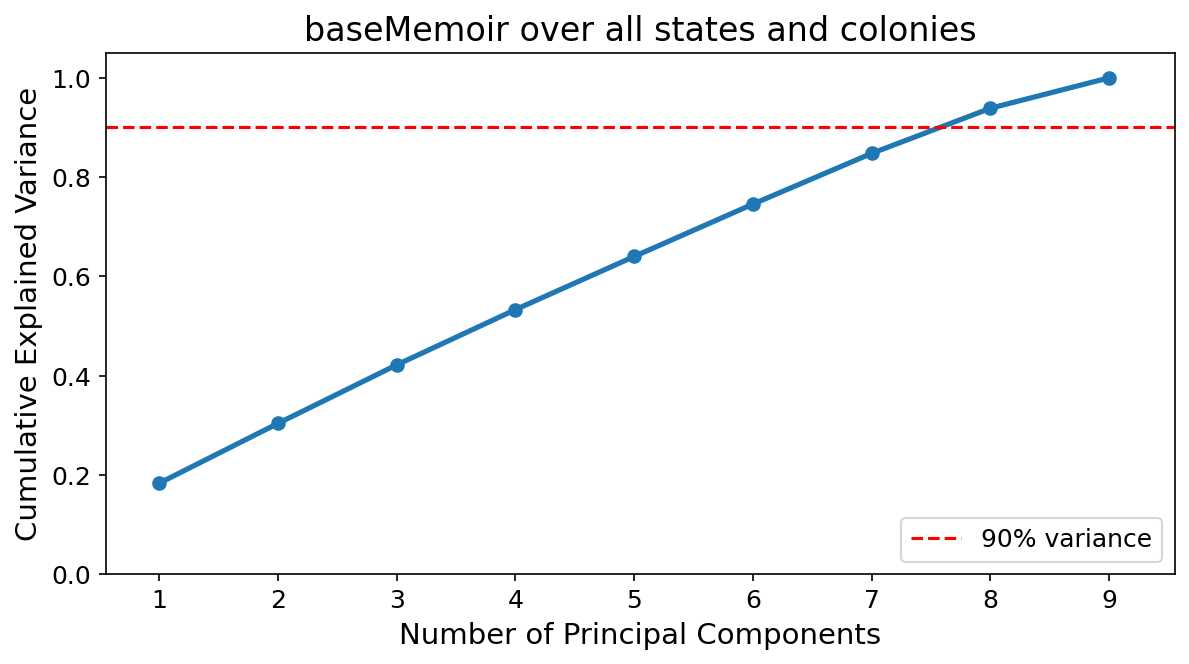

In [29]:
vr, cv = scree(X_train, out=f"{plot_dir}/PEtracer_scree.pdf")

In [30]:
df_train['clone'].value_counts(normalize=True)

clone
1    0.512037
2    0.291175
4    0.132614
3    0.064174
Name: proportion, dtype: float64

In [31]:
df_test['clone'].value_counts(normalize=True)

clone
1    0.510240
2    0.282646
4    0.137204
3    0.069911
Name: proportion, dtype: float64

#### Check if the features are correlated

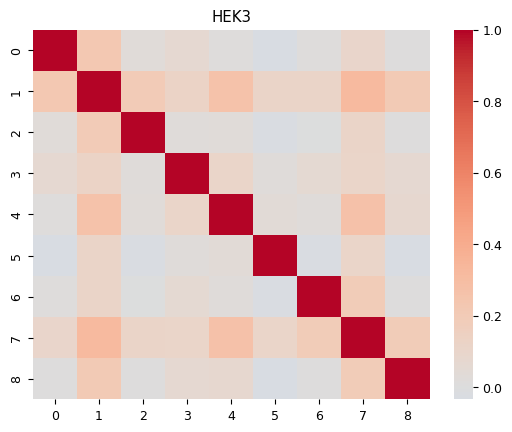

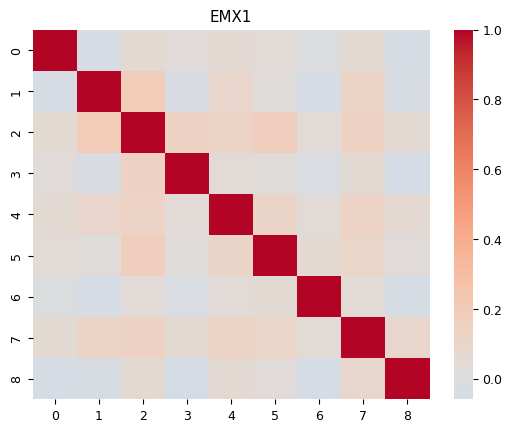

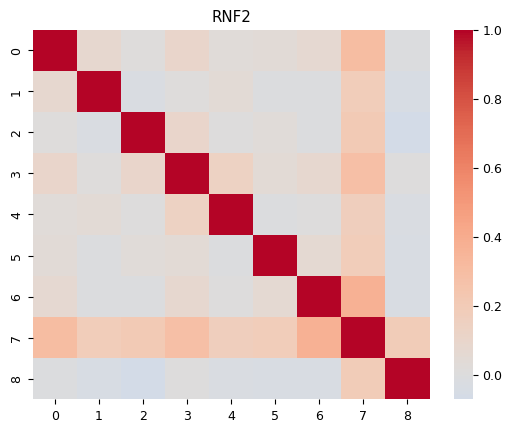

In [60]:
sites = df_train['target_site'].unique()
for site in sites:
    mask = df_train['target_site'] == site
    site_df = df_train.loc[mask]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df[feature_cols].values.copy())
    X_test = scaler.transform(site_df[feature_cols].values.copy())

    corr = pd.DataFrame(X_train).corr(numeric_only=True)
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(site)
    plt.show()

#### Evaluate z-norm or pca rotation of data

In [66]:
sites = df_train['target_site'].unique()
all_kde_dict_X, all_kde_dict_Z = {}, {}

for site in sites:
    mask = df_train['target_site'] == site
    site_df = df_train.loc[mask]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df[feature_cols].values.copy())

    pca = PCA(n_components=9, random_state=0, svd_solver='full', whiten=False)
    Z_train = pca.fit_transform(X_train.copy())

    all_kde_dict_X[site] = {}
    all_kde_dict_Z[site] = {}
    labels = site_df["seq_state"].unique()

    for lab in labels:
        m_train = site_df["seq_state"].eq(lab)   # boolean mask over df_train rows
        n = int(m_train.sum())
        if n < min_pts:
            continue

        X_block = X_train[m_train.values, :]   # raw feature space (scaled)
        Z_block = Z_train[m_train.values, :]   # PCA space

        kde_X = learn_kde(X_block)
        print(f"{site} {lab} [n={n}] kde(X) IMSE={kde_X.imse(kde_X.bw):.4g}")
        all_kde_dict_X[site][lab] = kde_X

        kde_Z = learn_kde(Z_block)
        print(f"{site} {lab} [n={n}] kde(Z) IMSE={kde_Z.imse(kde_Z.bw):.4g}")
        all_kde_dict_Z[site][lab] = kde_Z


HEK3 CTCTC [n=3882] kde(X) IMSE=-769
HEK3 CTCTC [n=3882] kde(Z) IMSE=-3.997
HEK3 CTTTG [n=7637] kde(X) IMSE=-796.9
HEK3 CTTTG [n=7637] kde(Z) IMSE=-56.39
HEK3 ATCAA [n=4124] kde(X) IMSE=-162.7
HEK3 ATCAA [n=4124] kde(Z) IMSE=-2.245
HEK3 unedited [n=6111] kde(X) IMSE=-717.2
HEK3 unedited [n=6111] kde(Z) IMSE=-16.01
HEK3 GATAG [n=3831] kde(X) IMSE=-275
HEK3 GATAG [n=3831] kde(Z) IMSE=-0.9871
HEK3 AATCG [n=948] kde(X) IMSE=-249.1
HEK3 AATCG [n=948] kde(Z) IMSE=-0.7242
HEK3 GCAAG [n=2911] kde(X) IMSE=-545.4
HEK3 GCAAG [n=2911] kde(Z) IMSE=-0.4569
HEK3 ATTTA [n=461] kde(X) IMSE=-138.1
HEK3 ATTTA [n=461] kde(Z) IMSE=-0.02535
HEK3 GCGCC [n=972] kde(X) IMSE=-76.32
HEK3 GCGCC [n=972] kde(Z) IMSE=-0.08334
EMX1 AGTAC [n=3824] kde(X) IMSE=-2151
EMX1 AGTAC [n=3824] kde(Z) IMSE=-1.262
EMX1 ACAAT [n=5551] kde(X) IMSE=-780.8
EMX1 ACAAT [n=5551] kde(Z) IMSE=-5.874
EMX1 CCTTT [n=4465] kde(X) IMSE=-1798
EMX1 CCTTT [n=4465] kde(Z) IMSE=-14.77
EMX1 unedited [n=6111] kde(X) IMSE=-1721
EMX1 unedited [n=6111]

In [67]:
for label in all_kde_dict_X['HEK3']:
    print(label, all_kde_dict_X['HEK3'][label].bw)

CTCTC [0.06367807 0.27991815 0.0971885  0.14403503 0.13313128 0.01675458
 1.174492   0.33589026 0.10595072]
CTTTG [0.06428129 0.27867647 0.09110788 0.16462315 0.87084865 0.05526806
 0.08401485 0.27134604 0.11599419]
ATCAA [0.07571389 0.32671576 0.08913126 0.15485011 0.15518563 1.13477651
 0.09869085 0.27386492 0.11251112]
unedited [0.07125209 0.29587189 0.10747063 0.16923979 0.15500938 0.02966924
 0.09655056 0.26320533 0.95678682]
GATAG [1.20830832 0.41512295 0.14440903 0.1938097  0.13408563 0.02128773
 0.10138031 0.24949085 0.10272765]
AATCG [0.07608442 2.26632007 0.30594159 0.21772061 0.163224   0.01932122
 0.1207873  0.29322921 0.11026638]
GCAAG [0.07468445 0.32602718 1.4692147  0.10803851 0.15752397 0.05371224
 0.11472426 0.2689379  0.12497235]
ATTTA [0.08621108 0.37982638 0.1506887  0.14123026 0.17762085 0.05029341
 0.11991073 3.50499051 0.14041544]
GCGCC [0.06991641 0.29444475 0.09511769 2.49966358 0.23222208 0.10557202
 0.13929984 0.26600149 0.09971374]


In [68]:
for label in all_kde_dict_X['EMX1']:
    print(label, all_kde_dict_X['EMX1'][label].bw)

AGTAC [0.17462708 0.04790856 0.19450743 1.21717796 0.12476178 0.1369094
 0.02950023 0.17950529 0.06097916]
ACAAT [0.03791759 0.9814834  0.33506434 0.06915273 0.18654129 0.15213756
 0.03201192 0.23770685 0.09885086]
CCTTT [0.0437874  0.05209734 0.20833076 0.06816447 0.14547463 1.12296441
 0.08406416 0.20967218 0.12033391]
unedited [0.03624732 0.09023933 0.20585353 0.04791536 0.18632952 0.18793984
 0.04014177 0.18524835 0.94326042]
GGACA [1.16749758 0.0588761  0.21020538 0.09898562 0.32607866 0.20006949
 0.07572955 0.21287217 0.09159434]
CCCTA [0.04319987 0.05606332 1.37378674 0.18788571 0.16134597 0.16146624
 0.04415866 0.23208075 0.05089675]
ATCAA [0.05962141 0.0503476  0.212267   0.07484956 0.18189088 0.14856487
 1.38373961 0.21203518 0.08870685]
CCGAT [0.0756514  0.10050212 0.33594048 0.10140703 4.09662086 0.35302802
 0.25225007 0.37745759 0.08444495]
ATTCG [0.04998182 0.18700249 0.13120781 0.05400236 0.13443628 0.10376319
 0.02371209 3.38972417 0.1316195 ]


In [69]:
for label in all_kde_dict_X['RNF2']:
    print(label, all_kde_dict_X['RNF2'][label].bw)

ACTCC [0.0970942  0.03152557 0.04816725 0.11246855 0.05817508 0.08303103
 0.09763812 0.94454373 0.02555819]
TCCAA [0.10942332 0.02050276 0.05685955 0.11923089 0.0540238  0.09640776
 1.13568607 0.53504701 0.07802316]
TGCCA [0.12029789 0.0318145  0.05551527 0.13825117 0.06891781 1.53063212
 0.15337582 0.44101723 0.06655104]
unedited [0.1101591  0.01709287 0.07572689 0.12637572 0.05733232 0.10805679
 0.13006632 0.42439191 0.92307965]
TATAT [0.11455899 0.03189309 0.06069021 1.57718844 0.23255735 0.09266288
 0.11993752 0.44442539 0.04026395]
TTCCT [0.11859918 0.04176654 0.94684176 0.19722013 0.08551069 0.10724961
 0.1039625  0.4398202  0.06641177]
GTTCA [0.14160966 0.04800729 0.05642749 0.15223334 2.61683845 0.10140192
 0.12125859 0.59927669 0.05734414]
ACAGT [1.25813566 0.12473208 0.06724086 0.16273532 0.08046479 0.1031561
 0.12136276 0.47950788 0.07721179]
ACTTA [0.14032776 1.7216078  0.06823381 0.13996415 0.15753757 0.10001681
 0.11647238 0.57750697 0.05616003]


#### Evaluate classification accuracy

Try splitting into sites before Z-normalizing (and PCA rotating).

In [71]:
df = long_df.copy()

In [72]:
gss = GroupShuffleSplit(test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["cellBC"]))
df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

In [73]:
sites = df_train['target_site'].unique()
all_kde_dict_X, all_kde_dict_Z = {}, {}

preds_X_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
preds_Z_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
scores_X_tables = []
scores_Z_tables = []

for site in sites:
    mask_train = df_train['target_site'] == site
    site_df_train = df_train.loc[mask_train]
    mask_test = df_test['target_site'] == site
    site_df_test = df_test.loc[mask_test]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df_train[feature_cols].values.copy())
    X_test = scaler.transform(site_df_test[feature_cols].values.copy())

    pca = PCA(n_components=9, random_state=0, svd_solver='full', whiten=False)
    Z_train = pca.fit_transform(X_train.copy())
    Z_test  = pca.transform(X_test.copy())

    all_kde_dict_X[site] = {}
    all_kde_dict_Z[site] = {}
    labels = site_df_train["seq_state"].unique()

    for lab in labels:
        m_train = site_df_train["seq_state"].eq(lab)   # boolean mask over df_train rows
        n = int(m_train.sum())
        if n < min_pts:
            continue

        X_block = X_train[m_train.values, :]   # raw feature space (scaled)
        Z_block = Z_train[m_train.values, :]   # PCA space

        kde_X = learn_kde(X_block)
        all_kde_dict_X[site][lab] = kde_X
        kde_Z = learn_kde(Z_block)
        all_kde_dict_Z[site][lab] = kde_Z

    # test
    pred_cols = ["pred_label","argmax_idx","argmax_logpdf"]
    
    # --- X space ---
    preds_X, scores_X = score_with_kdes(X_test, all_kde_dict_X[site])
    # write predictions into the preallocated frame using the boolean mask
    preds_X_full.loc[mask_test, pred_cols] = preds_X[pred_cols].to_numpy()
    # scores: align to df_test via the site’s original indices, then prefix columns
    scores_X.index = site_df_test.index
    scores_X = scores_X.add_prefix(f"{site}::")
    scores_X_tables.append(scores_X)
    print("Scored X...")
    
    # --- Z space ---
    preds_Z, scores_Z = score_with_kdes(Z_test, all_kde_dict_Z[site])
    preds_Z_full.loc[mask_test, pred_cols] = preds_Z[pred_cols].to_numpy()
    scores_Z.index = site_df_test.index
    scores_Z = scores_Z.add_prefix(f"{site}::")
    scores_Z_tables.append(scores_Z)
    print("Scored Z...")

Scored X...
Scored Z...
Scored X...
Scored Z...
Scored X...
Scored Z...


In [74]:
# Clean types
for df_ in (preds_X_full, preds_Z_full):
    df_["argmax_idx"] = pd.to_numeric(df_["argmax_idx"], errors="coerce")
    df_["argmax_logpdf"] = pd.to_numeric(df_["argmax_logpdf"], errors="coerce")

# Merge with metadata if you want a single output table
out = (
    df_test[["intID","target_site","seq_state","brightest_state", "pet_state"]]
    .join(preds_X_full.add_prefix("X_"))
    .join(preds_Z_full.add_prefix("Z_"))
)

In [75]:
out

,intID,target_site,seq_state,brightest_state,pet_state,X_pred_label,X_argmax_idx,X_argmax_logpdf,Z_pred_label,Z_argmax_idx,Z_argmax_logpdf
3,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,5.475300,CTCTC,0,0.420335
8,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,5.381970,CTCTC,0,0.341647
16,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,6.980329,CTCTC,0,1.580984
22,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,7.087427,CTCTC,0,1.511365
23,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,5.579780,CTCTC,0,-0.078843
...,...,...,...,...,...,...,...,...,...,...,...
131778,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,0.780992,TTCCT,5,-3.877704
131792,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,7.341831,ACTCC,0,4.506121
131796,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,4.472741,TTCCT,5,1.189546
131799,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,7.071293,ACTCC,0,1.794728


In [78]:
import numpy as np
import pandas as pd

def accuracy(y_true: pd.Series, y_pred: pd.Series, missing_token="missing"):
    # valid rows: not NA and not "missing" on both sides
    mask = y_true.notna() & y_pred.notna()
    if missing_token is not None:
        mask &= (y_true != missing_token) & (y_pred != missing_token)
    n = int(mask.sum())
    if n == 0:
        return np.nan
    return (y_true[mask] == y_pred[mask]).mean()

In [79]:
methods = {
    "brightest_state": "brightest_state_acc",
    "pet_state": "pet_state_acc",
    "X_pred_label": "X_pred_label_acc",
    "Z_pred_label": "Z_pred_label_acc",
}

acc_by_site = (
    out.groupby("target_site", dropna=False)
      .apply(lambda g: pd.Series({
          new_name: accuracy(g["seq_state"], g[col])
          for col, new_name in methods.items()
      }))
      .reset_index()
)

overall = {
    new_name: accuracy(out["seq_state"], out[col])
    for col, new_name in methods.items()
}

overall_row = pd.DataFrame([{"target_site": "Total", **overall}])
acc_by_site_with_total = pd.concat([acc_by_site, overall_row], ignore_index=True)

acc_by_site_with_total


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/607155923.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,target_site,brightest_state_acc,pet_state_acc,X_pred_label_acc,Z_pred_label_acc
0,EMX1,0.974345,0.978174,0.942104,0.876857
1,HEK3,0.971818,0.980548,0.964236,0.890335
2,RNF2,0.986292,0.987517,0.948078,0.852811
3,Total,0.977485,0.982080,0.951473,0.873334


In [76]:
out['X_argmax_logpdf'].describe()

count    39174.000000
mean         4.644465
std          9.993238
min       -690.775528
25%          3.951014
50%          5.905004
75%          7.011139
max         12.106122
Name: X_argmax_logpdf, dtype: float64

In [77]:
out['Z_argmax_logpdf'].describe()

count    39174.000000
mean        -0.013124
std          7.017420
min       -549.319773
25%         -1.326814
50%          0.625840
75%          2.020397
max          8.842374
Name: Z_argmax_logpdf, dtype: float64

results from z-normalizing once at the beginning, crazy bw

In [43]:
out['X_argmax_logpdf'].describe()

count    39174.000000
mean         6.577434
std          3.868128
min       -213.440612
25%          5.193011
50%          7.149360
75%          8.506485
max         11.269590
Name: X_argmax_logpdf, dtype: float64

In [44]:
out['Z_argmax_logpdf'].describe()

count    39174.000000
mean         0.210345
std          4.871924
min       -337.652485
25%         -1.755016
50%          0.393164
75%          2.798400
max          8.108003
Name: Z_argmax_logpdf, dtype: float64

In [ ]:
### think about how to rescale these

In [45]:
# load in the simulated data -> what does the logpdf of these scores look like that's more reasonable? 
sim_data_scores = pd.read_csv("/Users/gc3045/git/laml2-experiments/sim_data/set_3d/input/k400_s0_sub100_r01/k400_s0_sub100_r01_dim3_r0.607_p0.0_scores.csv")

In [47]:
sim_data_scores['state0_prob'].describe()

count    40000.000000
mean        -3.576597
std          2.261485
min        -21.003173
25%         -4.737841
50%         -3.017814
75%         -1.868654
max         -0.679672
Name: state0_prob, dtype: float64

Need to specify that `svd_solver=full`. Whitening before PCA decorrelates each feature, but so does the PCA rotation. Recall that we train an anisotropic KDE with a diagonal bandwidth. Our product kernel (in statsmodels) is not rotation independent. The rotated matrix Z has very unequal bandwidths, so the numeric value of IMSE can change a lot. 

### Final stage: reformat and save test data (Clone 2)

In [141]:
print("Ready to add in kde preds and scores!")

Ready to add in kde preds and scores!


In [142]:
df_clean = df_test.copy()

In [143]:
# use_scores = scores_X_tables
# use_preds = preds_X_full

use_scores = scores_Z_tables
use_preds = preds_Z_full

In [144]:
df_clean['kde_pred_string'] = use_preds['pred_label']

all_idx = [x.index for x in use_scores]

for i, idx in enumerate(all_idx):
    dupes = idx[idx.duplicated()]
    if len(dupes):
        print(f"[warn] use_scores[{i}] has {len(dupes)} duplicate indices!")
    else:
        print(f"[ok] use_scores[{i}] indices are unique.")

[ok] use_scores[0] indices are unique.
[ok] use_scores[1] indices are unique.
[ok] use_scores[2] indices are unique.


In [145]:
all_idx = pd.Index([]).append([x.index for x in use_scores])

# check equality with df_clean
print("same length:", len(all_idx) == len(df_clean))
print("same members:", set(all_idx) == set(df_clean.index))

same length: True
same members: True


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/1325895239.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_idx = pd.Index([]).append([x.index for x in use_scores])


In [146]:
site_states = {}

for df in use_scores:
    for c in df.columns:
        if "::state" not in c:
            continue
        site, label = c.split("::state")
        label = label.replace("_prob", "")
        site_states.setdefault(site, set()).add(label)

# --- Build the codebook ---
rows = []
for site, labels in site_states.items():
    # ensure 'unedited' is 0, others get 1..8 sorted alphabetically
    labels_sorted = sorted([l for l in labels if l != "unedited"])
    ordered = ["unedited"] + labels_sorted
    for i, lbl in enumerate(ordered):
        rows.append({"site": site, "label": lbl, "code": i})

label_codebook = pd.DataFrame(rows).sort_values(["site", "code"], ignore_index=True)
print(label_codebook)
label_codebook.to_csv(out_dir + "/label_codebook.csv", index=False) 

    site     label  code
0   EMX1  unedited     0
1   EMX1     ACAAT     1
2   EMX1     AGTAC     2
3   EMX1     ATCAA     3
4   EMX1     ATTCG     4
5   EMX1     CCCTA     5
6   EMX1     CCGAT     6
7   EMX1     CCTTT     7
8   EMX1     GGACA     8
9   HEK3  unedited     0
10  HEK3     AATCG     1
11  HEK3     ATCAA     2
12  HEK3     ATTTA     3
13  HEK3     CTCTC     4
14  HEK3     CTTTG     5
15  HEK3     GATAG     6
16  HEK3     GCAAG     7
17  HEK3     GCGCC     8
18  RNF2  unedited     0
19  RNF2     ACAGT     1
20  RNF2     ACTCC     2
21  RNF2     ACTTA     3
22  RNF2     GTTCA     4
23  RNF2     TATAT     5
24  RNF2     TCCAA     6
25  RNF2     TGCCA     7
26  RNF2     TTCCT     8


In [147]:
# make sure df_clean has 9 columns ready (will fill in order)
for i in range(9):
    col = f"state{i}_prob"
    if col not in df_clean.columns:
        df_clean[col] = pd.NA  # initialize

for site, df_scores in zip(sites, use_scores):
    # ensure we’re using the actual indices from this score table
    idx = df_scores.index  

    # mapping: label -> code
    site_map = (
        label_codebook.query("site == @site")
        .set_index("label")["code"]
        .to_dict()
    )

    for col in df_scores.columns:
        m = re.match(r"(.+)::state(.+)_prob", col)
        if not m:
            continue
        _, label = m.groups()
        code = site_map.get(label.strip())
        if code is None:
            continue

        target_col = f"state{code}_prob"
        df_clean.loc[idx, target_col] = df_scores[col].values
        
state_cols = sorted(
    [c for c in df_clean.columns if re.match(r"state\d+_prob", c)],
    key=lambda x: int(re.search(r"\d+", x).group())
)
other_cols = [c for c in df_clean.columns if c not in state_cols]
df_clean = df_clean[other_cols + state_cols]

df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,CTCTC,-9.831797,-28.435327,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,CTCTC,-5.087847,-32.732905,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829
16,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,CTCTC,-3.21421,-11.077094,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136
22,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,CTCTC,-0.567538,-6.459694,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741
23,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,CTCTC,-7.481085,-38.291063,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,TTCCT,-40.720491,-21.431341,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704
131792,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,ACTCC,2.083553,0.056916,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309
131796,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,TTCCT,-4.946078,-6.340799,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546
131799,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,ACTCC,1.753395,-0.532459,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004


In [148]:
print("Ready to save!")

Ready to save!


In [149]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

In [150]:
id_cols = ["cellBC", "intID", "clone", "x", "y", "z"]

In [151]:
df_clean['clone'].unique()

array([2, 1, 4, 3])

In [152]:
# subset to clone 2
mask = df_clean['clone'] == 2
df_clean = df_clean[mask]
df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,CTCTC,-9.831797,-28.435327,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,CTCTC,-5.087847,-32.732905,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829
16,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,CTCTC,-3.21421,-11.077094,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136
22,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,CTCTC,-0.567538,-6.459694,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741
23,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,CTCTC,-7.481085,-38.291063,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,TTCCT,-40.720491,-21.431341,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704
131792,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,ACTCC,2.083553,0.056916,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309
131796,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,TTCCT,-4.946078,-6.340799,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546
131799,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,ACTCC,1.753395,-0.532459,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004


In [153]:
# add the target site annotation AFTER we subset
unique_cassettes = df_clean['intID'].unique()
cassette_mapping = {id_: i for i, id_ in enumerate(unique_cassettes)}
df_clean["cassette_idx"] = df_clean["intID"].map(cassette_mapping)

site_mapping = {'RNF2': 0, 'HEK3': 1, 'EMX1': 2}
df_clean['target_idx'] = df_clean['target_site'].map(site_mapping) + len(site_mapping) * df_clean["cassette_idx"]

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/2587941934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["cassette_idx"] = df_clean["intID"].map(cassette_mapping)
/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/2587941934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['target_idx'] = df_clean['target_site'].map(site_mapping) + len(site_mapping) * df_clean["cassette_idx"]


In [154]:
df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob,cassette_idx,target_idx
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,-28.435327,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856,0,1
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,-32.732905,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829,0,1
16,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,-11.077094,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136,0,1
22,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,-6.459694,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741,0,1
23,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,-38.291063,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,-21.431341,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704,19,57
131792,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,0.056916,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309,19,57
131796,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,-6.340799,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546,19,57
131799,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,-0.532459,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004,19,57


#### Save a label codebook

In [155]:
df_clean = df_clean.merge(
    label_codebook.rename(columns={
        "site": "target_site",
        "label": "kde_pred_string",
        "code": "kde_pred_label"
    }),
    on=["target_site", "kde_pred_string"],
    how="left"
)

lookup_codebook = (
    df_clean[["target_idx", "kde_pred_string", "kde_pred_label"]]
    .drop_duplicates()
    .sort_values(["target_idx", "kde_pred_label"], ignore_index=True)
)

lookup_codebook.to_csv(out_dir + "/lookup_codebook.csv", index=False)

In [172]:
lookup_codebook

,target_idx,kde_pred_string,kde_pred_label
0,0,ACTCC,2
1,0,TATAT,5
2,1,unedited,0
3,1,CTCTC,4
4,1,CTTTG,5
...,...,...,...
200,59,unedited,0
201,59,ACAAT,1
202,59,ATTCG,4
203,59,CCCTA,5


In [156]:
df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob,cassette_idx,target_idx,kde_pred_label
0,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856,0,1,4
1,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829,0,1,4
2,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136,0,1,4
3,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741,0,1,4
4,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704,19,57,8
10766,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309,19,57,2
10767,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546,19,57,8
10768,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004,19,57,2


#### Save multiple files
- Construct the argmax character matrix
- Construct the df_test with PEtracer probabilities
- Construct the kde scores csv for observation matrix. Don't forget the column of cassette_idx=0!

In [157]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'target_site', 'pet_state', 'seq_state',
       'brightest_state', 'pet_prob', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_0_bit', 'feature_0_edit', 'feature_1_bit',
       'feature_1_edit', 'feature_2_bit', 'feature_2_edit', 'feature_3_bit',
       'feature_3_edit', 'feature_4_bit', 'feature_4_edit', 'feature_5_bit',
       'feature_5_edit', 'feature_6_bit', 'feature_6_edit', 'feature_7_bit',
       'feature_7_edit', 'feature_8_bit', 'feature_8_edit', 'kde_pred_string',
       'state0_prob', 'state1_prob', 'state2_prob', 'state3_prob',
       'state4_prob', 'state5_prob', 'state6_prob', 'state7_prob',
       'state8_prob', 'cassette_idx', 'target_idx', 'kde_pred_label'],
      dtype='object')

In [158]:
tbl = df_clean[['target_idx', 'cellBC', 'kde_pred_label']]
tbl.columns = ['target_site', 'cell_name', 'pred_label']

In [159]:
sorted(tbl['target_site'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(49),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(57),
 np.int64(58),
 np.int64(59)]

In [160]:
len(tbl['target_site'].unique())

60

In [161]:
kde_inputs_argmax = reshape_to_cmat(tbl).T

In [162]:
kde_inputs_argmax.to_csv(out_dir + "/petracer_clone2_kde_character_matrix.csv")

Save the PEtracer probabilities now. 

In [163]:
clone=2

In [164]:
sorted(df_clean['target_idx'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(49),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(57),
 np.int64(58),
 np.int64(59)]

In [165]:
# [id_cols + ["cassette_idx", "target_idx", "target_site", "seq_state", "pet_state", "brightest_state", "pet_prob"]]
petracer_df = df_clean.copy()
petracer_path = os.path.join(out_dir, f"petracer_clone{clone}_petracer_genotypes.csv")
petracer_df.to_csv(petracer_path, index=False)


And now save the KDE log-density 'observation matrix'.

In [166]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'target_site', 'pet_state', 'seq_state',
       'brightest_state', 'pet_prob', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_0_bit', 'feature_0_edit', 'feature_1_bit',
       'feature_1_edit', 'feature_2_bit', 'feature_2_edit', 'feature_3_bit',
       'feature_3_edit', 'feature_4_bit', 'feature_4_edit', 'feature_5_bit',
       'feature_5_edit', 'feature_6_bit', 'feature_6_edit', 'feature_7_bit',
       'feature_7_edit', 'feature_8_bit', 'feature_8_edit', 'kde_pred_string',
       'state0_prob', 'state1_prob', 'state2_prob', 'state3_prob',
       'state4_prob', 'state5_prob', 'state6_prob', 'state7_prob',
       'state8_prob', 'cassette_idx', 'target_idx', 'kde_pred_label'],
      dtype='object')

In [167]:
state_cols = [c for c in df_clean.columns if re.match(r"state\d+_prob", c)]
obs_matrix = df_clean[["cellBC", "cassette_idx", "target_idx"] + state_cols].copy().rename(columns={"cellBC": "cell_name", "target_idx": "target_site"})
obs_matrix["cassette_idx"] = 0
obs_matrix = obs_matrix.sort_values(by="target_site", ascending=True)
# obs_matrix[state_cols] = obs_matrix[state_cols] - 250
petracer_path = os.path.join(out_dir, f"petracer_clone{clone}_kde_scores.csv")
obs_matrix.to_csv(petracer_path, index=False)


In [168]:
obs_matrix[state_cols].max().max()

8.776046962517373

### Save all the clean data as training!

In [169]:
clean_df2 = long_df.copy()

In [170]:
clean_df2['clone'].value_counts()

clone
1    67419
2    38046
4    17658
3     8682
Name: count, dtype: int64

In [171]:
clean_df2.to_csv(out_dir + "petracer_full_training.csv", index=False)